In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utm
from sklearn.preprocessing import StandardScaler

### Run coordinate transformation with the territories

In [12]:
# Load dataset with longitude, latitude and altitude for all marked territories from the orthomosaic
map_coordinates = pd.read_csv('/Users/vivekhsridhar/Library/Mobile Documents/com~apple~CloudDocs/Documents/Metashape/TalChhapar/output/territories_xyz.txt', header=None)
map_coordinates = map_coordinates.iloc[:,:4]
map_coordinates.columns = ['Point', 'Longitude', 'Latitude', 'Altitude']
map_coordinates.head()

,Point,Longitude,Latitude,Altitude
0,1,74.436945,27.800021,287.9558
1,2,74.436766,27.800038,288.3593
2,3,74.436602,27.799934,288.8230
3,4,74.436794,27.799810,288.5657
4,5,74.437163,27.799771,287.6457


In [13]:
# Load dataset with longitude, latitude and altitude per frame based on results from metashape
frame_coordinates = pd.read_csv('/Users/vivekhsridhar/Library/Mobile Documents/com~apple~CloudDocs/Documents/Code/Python/SpatialRegistration/io/20230302_SM_Lek1_P2D4_DJI_0571_3D_territories_seq.csv')
frame_coordinates.head()

,Point,Camera,Video,frame,u,v,x,y,z
0,39,20230302_SM_Lek1_P2D4_DJI_0571_frame0,20230302_SM_Lek1_P2D4_DJI_0571,0.0,4629.324,62.988,74.437598,27.799206,196.953116
1,30,20230302_SM_Lek1_P2D4_DJI_0571_frame0,20230302_SM_Lek1_P2D4_DJI_0571,0.0,3705.432,104.163,74.437283,27.799404,198.669868
2,33,20230302_SM_Lek1_P2D4_DJI_0571_frame0,20230302_SM_Lek1_P2D4_DJI_0571,0.0,2883.900,205.713,74.436990,27.799559,200.284091
3,31,20230302_SM_Lek1_P2D4_DJI_0571_frame0,20230302_SM_Lek1_P2D4_DJI_0571,0.0,3570.399,200.589,74.437213,27.799406,199.152924
4,38,20230302_SM_Lek1_P2D4_DJI_0571_frame0,20230302_SM_Lek1_P2D4_DJI_0571,0.0,4719.234,192.165,74.437594,27.799148,197.042563


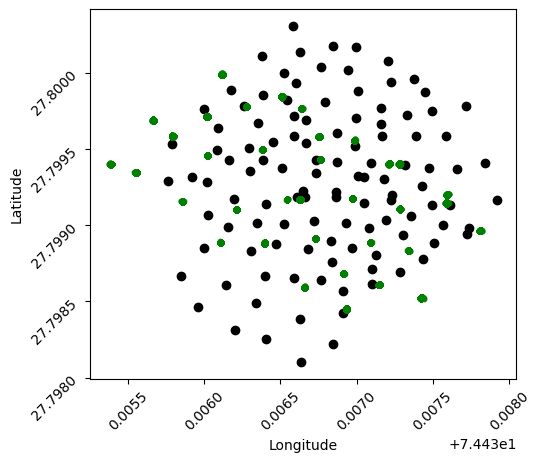

In [14]:
# Plot original and computed coordinates
plt.scatter(map_coordinates['Longitude'], map_coordinates['Latitude'], c='black', label='Original Coordinates')
plt.scatter(frame_coordinates['x'], frame_coordinates['y'], c='green', s=10, alpha=0.8, label='Computed Coordinates')
plt.gca().set_aspect('equal', adjustable='box')

# Adding labels and legend
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()

In [15]:
# Group by Camera in frame_coordinates and initialize transformation matrices and results list
cameras = frame_coordinates['Camera'].unique()
transformation_matrices = {}
results = []

for camera in cameras:
    # Extract points for the current camera
    tmp = frame_coordinates[frame_coordinates['Camera'] == camera]
    
    # Merge with map_coordinates based on the Point column
    tmp_merged = pd.merge(tmp, map_coordinates, on='Point')
    
    # Extract coordinates
    map_subset = tmp_merged[['Longitude', 'Latitude']].to_numpy()
    frame_subset = tmp_merged[['x', 'y']].to_numpy()
    
    # Calculate the centroids
    map_centroid = np.mean(map_subset, axis=0)
    frame_centroid = np.mean(frame_subset, axis=0)
    
    # Center the points
    map_centered = map_subset - map_centroid
    frame_centered = frame_subset - frame_centroid
    
    # Compute the scaling factor using the least-squares method
    scaling_factor = np.linalg.lstsq(frame_centered, map_centered, rcond=None)[0]
    
    # Apply the scaling and translation
    frame_coordinates_computed = (frame_centered @ scaling_factor) + map_centroid
    
    # Store the transformation matrix (scaling and translation)
    transformation_matrices[camera] = (scaling_factor, frame_centroid, map_centroid)
    
    # Add computed coordinates to the merged dataframe
    tmp_merged['LongitudeComputed'] = frame_coordinates_computed[:, 0]
    tmp_merged['LatitudeComputed'] = frame_coordinates_computed[:, 1]
    
    # Append the merged dataframe to the results list
    results.append(tmp_merged)

# Concatenate all results into a single dataframe
df_results = pd.concat(results)
df_results = df_results.loc[:,['Point', 'Camera', 'frame', 'u', 'v', 'LongitudeComputed', 'LatitudeComputed']].reset_index()

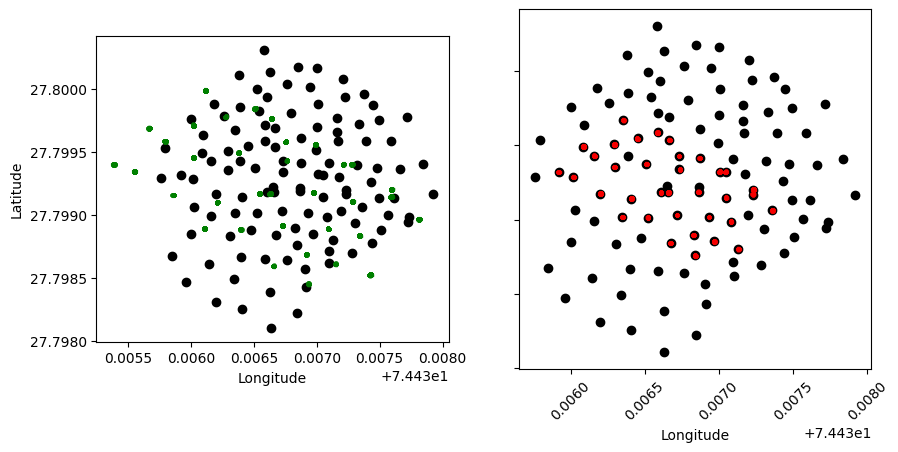

In [16]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(10,5), sharey=True)

# Plot original and computed coordinates
ax1.scatter(map_coordinates['Longitude'], map_coordinates['Latitude'], c='black', label='Original Coordinates')
ax1.scatter(frame_coordinates['x'], frame_coordinates['y'], c='green', s=5, alpha=0.1, label='Computed Coordinates')
ax1.set_aspect('equal', adjustable='box')

ax2.scatter(map_coordinates['Longitude'], map_coordinates['Latitude'], c='black', label='Original Coordinates')
ax2.scatter(df_results['LongitudeComputed'], df_results['LatitudeComputed'], c='red', s=5, alpha=0.1, label='Computed Coordinates')
ax2.set_aspect('equal', adjustable='box')

# Adding labels and legend
ax1.set_xlabel('Longitude')
ax2.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()

In [17]:
# Merge the DataFrames
df_merged = df_results.merge(map_coordinates, on='Point', how='left')
df_merged.head()

,index,Point,Camera,frame,u,v,LongitudeComputed,LatitudeComputed,Longitude,Latitude,Altitude
0,0,39,20230302_SM_Lek1_P2D4_DJI_0571_frame0,0.0,4629.324000,62.988000,74.437234,27.799205,74.437233,27.799202,287.6757
1,1,39,20230302_SM_Lek1_P2D4_DJI_0571_frame0,0.0,4629.466797,62.954952,74.437234,27.799205,74.437233,27.799202,287.6757
2,2,39,20230302_SM_Lek1_P2D4_DJI_0571_frame0,0.0,4629.868164,63.059536,74.437234,27.799205,74.437233,27.799202,287.6757
3,3,39,20230302_SM_Lek1_P2D4_DJI_0571_frame0,0.0,4629.838379,62.646187,74.437234,27.799205,74.437233,27.799202,287.6757
4,4,39,20230302_SM_Lek1_P2D4_DJI_0571_frame0,0.0,4629.393555,62.355667,74.437234,27.799205,74.437233,27.799202,287.6757


In [18]:
utm_map = utm.from_latlon(df_merged.loc[:,'Latitude'].values, df_merged.loc[:,'Longitude'].values)
utm_frame = utm.from_latlon(df_merged.loc[:,'LatitudeComputed'].values, df_merged.loc[:,'LongitudeComputed'].values)

In [19]:
df_merged['Easting'] = utm_map[0]
df_merged['Northing'] = utm_map[1]
df_merged['EastingComputed'] = utm_frame[0]
df_merged['NorthingComputed'] = utm_frame[1]

df_merged['Distance'] = np.sqrt((df_merged['Easting'] - df_merged['EastingComputed'])**2 + (df_merged['Northing'] - df_merged['NorthingComputed'])**2)

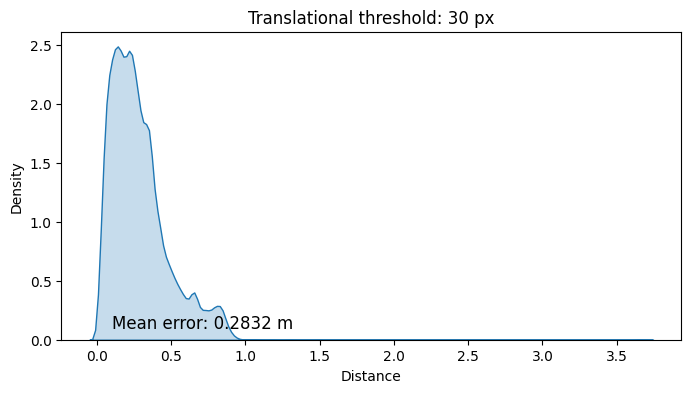

In [20]:
fig,ax = plt.subplots(1,1, figsize=(8,4))

sns.kdeplot(df_merged['Distance'], fill=True, ax=ax)
plt.title('Translational threshold: 30 px')
plt.text(x=0.1, y=0.1, s='Mean error: ' + str(df_merged['Distance'].mean().round(4)) + ' m', fontsize=12)
plt.show()

### Run the same coordinate transformation with the blackbuck trajectories

In [8]:
trajectory_coordinates = pd.read_csv('/Users/vivekhsridhar/Library/Mobile Documents/com~apple~CloudDocs/Documents/Metashape/TalChhapar/output/trajectories_3D_world.csv')
trajectory_coordinates.head()

,idx,Camera,u,v,x,y,z
0,1,frame0,357.5,2466.0,74.435675,27.800005,222.843140
1,2,frame0,3767.0,1461.0,74.437417,27.799348,224.148663
2,3,frame0,4244.5,1834.5,74.437489,27.799073,224.556648
3,4,frame0,4189.5,2203.0,74.437346,27.798956,224.973970
4,5,frame0,3859.0,2052.5,74.437262,27.799111,225.013752


In [9]:
# Create a list to store transformed results for each camera
transformed_results = []

# Iterate over each camera in the dictionary
for camera, (scaling_factor, frame_centroid, map_centroid) in transformation_matrices.items():
    # Extract the coordinates for the current camera
    tmp = trajectory_coordinates[trajectory_coordinates['Camera'] == camera]
    inclusive_coordinates = tmp.loc[:, ['idx', 'x', 'y']].values
    
    # If you need to transform new points using the stored transformation
    exclusive_coordinates = inclusive_coordinates[:, 1:]  # Extract 'x' and 'y' columns
    centered_coordinates = exclusive_coordinates - frame_centroid
    transformed_coordinates = (centered_coordinates @ scaling_factor) + map_centroid
    
    # Create a DataFrame with the transformed coordinates
    transformed_df = pd.DataFrame({
        'idx': inclusive_coordinates[:, 0],
        'LongitudeComputed': transformed_coordinates[:, 0],
        'LatitudeComputed': transformed_coordinates[:, 1]
    })
    
    # Merge the transformed coordinates back with the original dataframe
    tmp_merged = pd.merge(tmp, transformed_df, on='idx')
    
    # Append the result to the list
    transformed_results.append(tmp_merged)

# Concatenate all transformed results into a single dataframe
df_transformed_results = pd.concat(transformed_results)

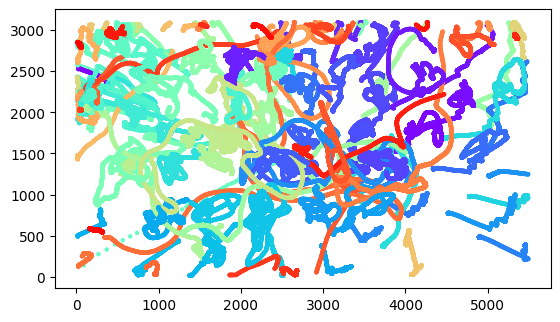

In [10]:
# Create the scatter plots
plt.scatter(trajectory_coordinates['u'], trajectory_coordinates['v'], c=trajectory_coordinates['idx'], cmap='rainbow', s=5)

# Maintain equal aspect ratio
plt.gca().set_aspect('equal', adjustable='box')

# Show the plot
plt.show()

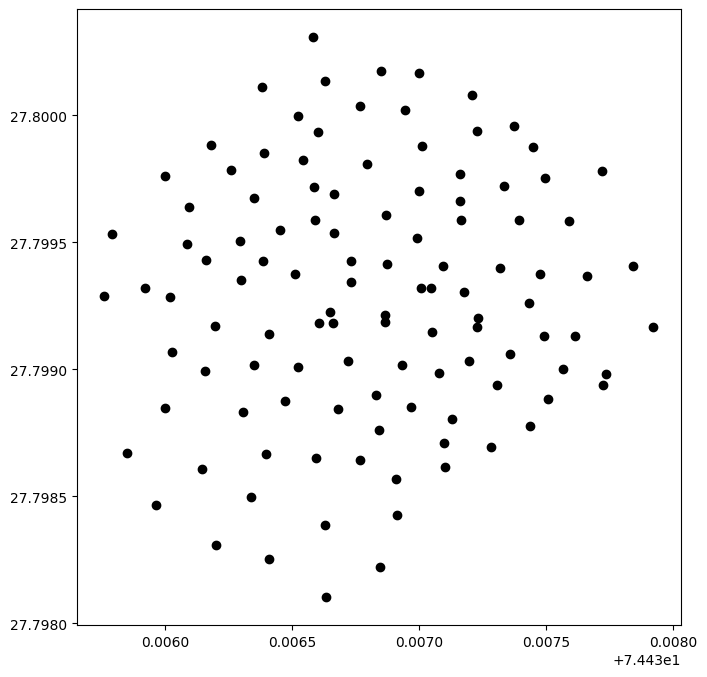

In [11]:
# Set the figure size (width, height) in inches
plt.figure(figsize=(12, 8))  # You can adjust these values as needed

# Create the scatter plots
plt.scatter(map_coordinates['Longitude'], map_coordinates['Latitude'], c='black')
plt.scatter(df_transformed_results['LongitudeComputed'], df_transformed_results['LatitudeComputed'], c=df_transformed_results['idx'], cmap='rainbow', s=1, alpha=0.4)

# Maintain equal aspect ratio
plt.gca().set_aspect('equal', adjustable='box')

# Show the plot
plt.show()